### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# setting up the chart size and background
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('fivethirtyeight')

# for Interactive Shells
from IPython.display import display

## Data

In [2]:
df = pd.read_csv('../DATA/gene_expression.csv')

In [3]:
df.head()

,Gene One,Gene Two,Cancer Present
0,4.3,3.9,1
1,2.5,6.3,0
2,5.7,3.9,1
3,6.1,6.2,0
4,7.4,3.4,1


<AxesSubplot:xlabel='Gene One', ylabel='Gene Two'>

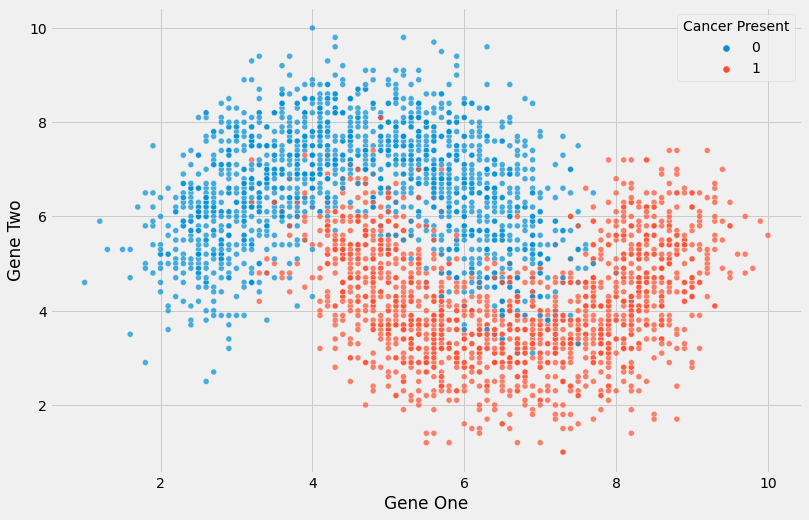

In [4]:
sns.scatterplot(x='Gene One',y='Gene Two',hue='Cancer Present',data=df,alpha=0.7)

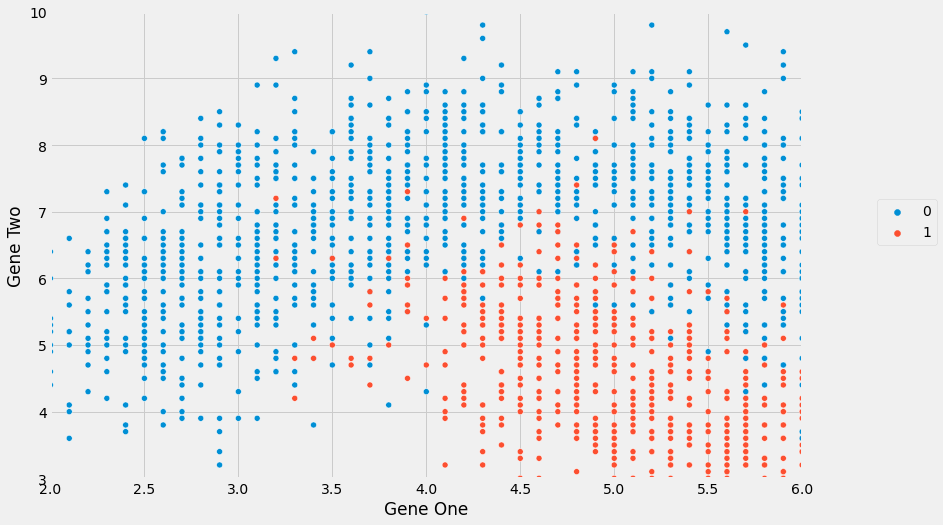

In [5]:
sns.scatterplot(x='Gene One',y='Gene Two',hue='Cancer Present',data=df)
plt.xlim(2,6)
plt.ylim(3,10)
plt.legend(loc=(1.1,0.5))

## Train|Test Split and Scaling Data

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [7]:
X = df.drop('Cancer Present',axis=1)
y = df['Cancer Present']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
scaler = StandardScaler()

In [10]:
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [11]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=1)
knn_model.fit(scaled_X_train,y_train)

KNeighborsClassifier(n_neighbors=1)

### Choosing K Value

In [12]:
full_test = pd.concat([X_test,y_test],axis=1)

In [13]:
len(full_test)

900

<AxesSubplot:xlabel='Gene One', ylabel='Gene Two'>

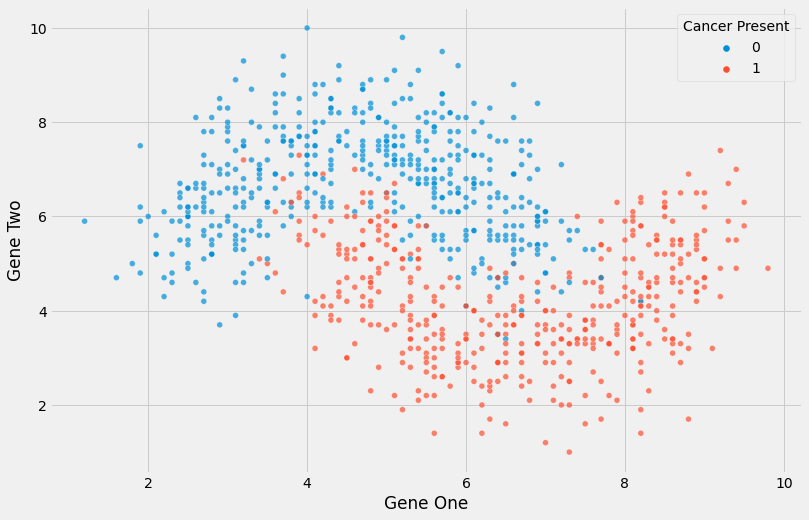

In [14]:
sns.scatterplot(x='Gene One',y='Gene Two',hue='Cancer Present',
                data=full_test,alpha=0.7)

## Model Evaluation

In [15]:
y_pred = knn_model.predict(scaled_X_test)

In [16]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [17]:
accuracy_score(y_test,y_pred)

0.8922222222222222

In [18]:
confusion_matrix(y_test,y_pred)

array([[420,  50],
       [ 47, 383]], dtype=int64)

In [19]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90       470
           1       0.88      0.89      0.89       430

    accuracy                           0.89       900
   macro avg       0.89      0.89      0.89       900
weighted avg       0.89      0.89      0.89       900



### Elbow Method for Choosing Reasonable K Values

In [20]:
test_error_rates = []


for k in range(1,30):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(scaled_X_train,y_train) 
   
    y_pred_test = knn_model.predict(scaled_X_test)
    
    test_error = 1 - accuracy_score(y_test,y_pred_test)
    test_error_rates.append(test_error)

Text(0.5, 0, 'K Value')

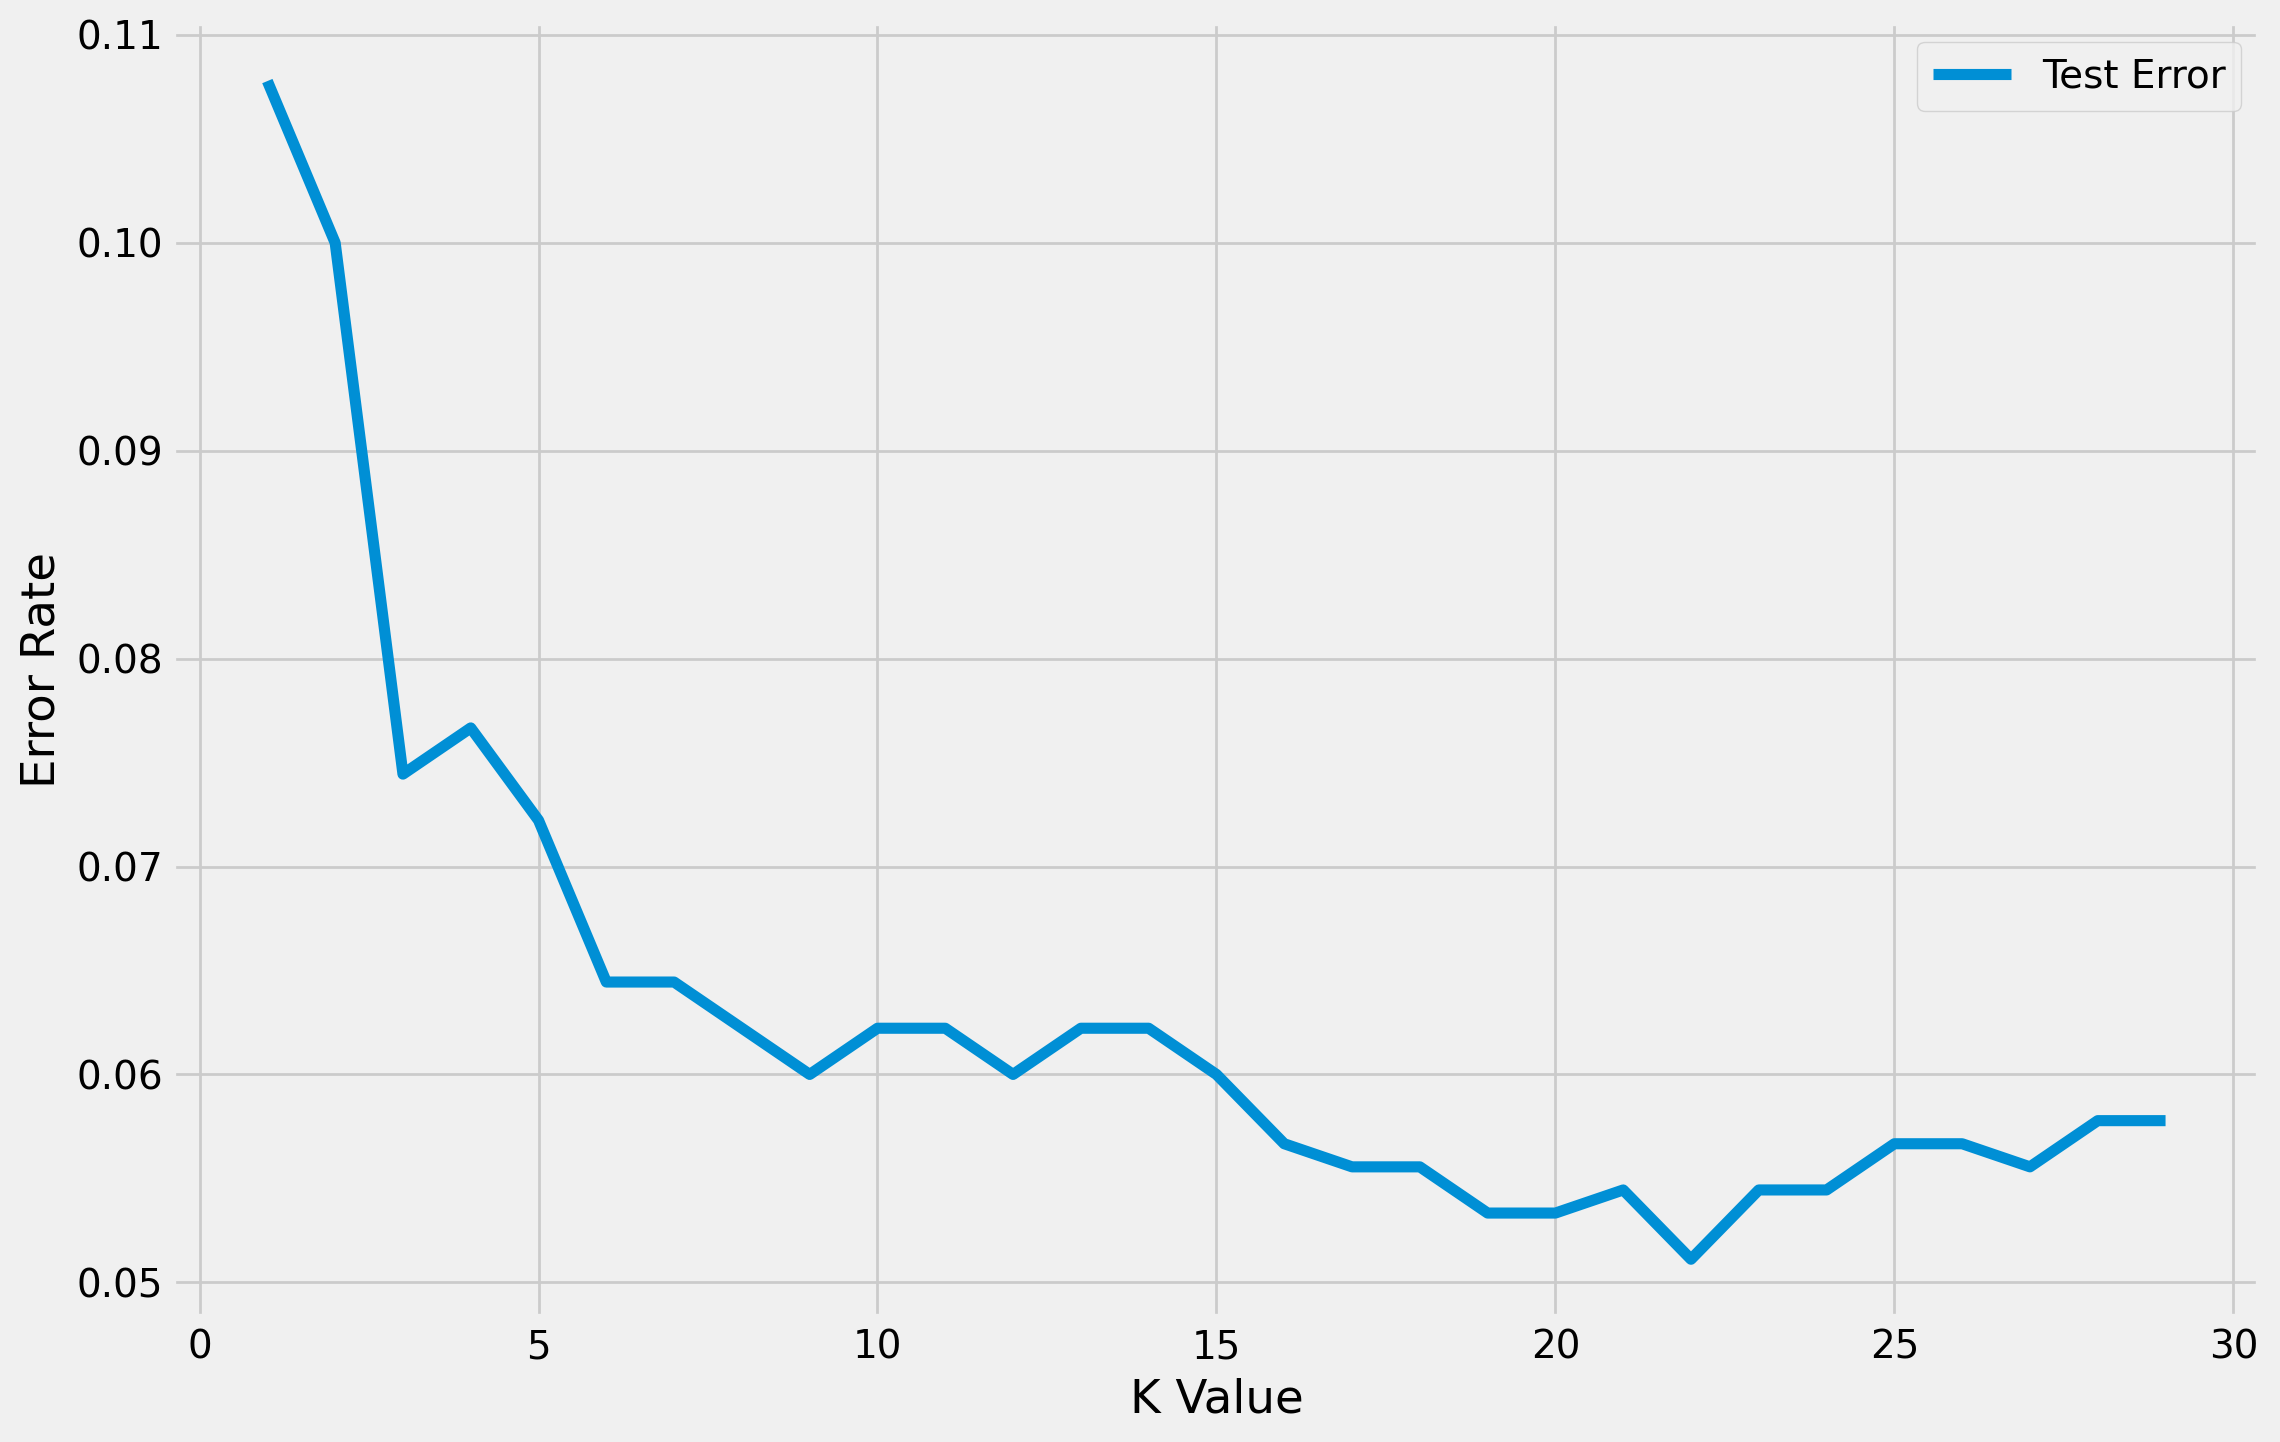

In [21]:
plt.figure(dpi=200)
plt.plot(range(1,30),test_error_rates,label='Test Error')
plt.legend()
plt.ylabel('Error Rate')
plt.xlabel("K Value")

### Full Cross Validation Grid Search for K Value

### Creating a Pipeline to find K value

In [22]:
scaler = StandardScaler()
knn = KNeighborsClassifier()

knn.get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [23]:
operations = [('scaler',scaler),('knn',knn)]

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipe = Pipeline(operations)

In [25]:
k_values = list(range(1,20))

In [26]:
k_values

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [27]:
param_grid = {'knn__n_neighbors': k_values}

In [28]:
full_cv_classifier = GridSearchCV(pipe,param_grid,cv=5,scoring='accuracy')

In [29]:
full_cv_classifier.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19]},
             scoring='accuracy')

In [30]:
full_cv_classifier.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=14))],
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(n_neighbors=14),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 14,
 'knn__p': 2,
 'knn__weights': 'uniform'}

In [31]:
full_cv_classifier.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_knn__n_neighbors', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

Let's check our understanding:
**How many total runs did we do?**

In [32]:
len(k_values)

19

In [33]:
full_cv_classifier.cv_results_['mean_test_score']

array([0.90238095, 0.90285714, 0.91857143, 0.91333333, 0.92380952,
       0.92142857, 0.9252381 , 0.9247619 , 0.9252381 , 0.92190476,
       0.9252381 , 0.9247619 , 0.92761905, 0.92904762, 0.92809524,
       0.92809524, 0.92904762, 0.92857143, 0.92761905])

In [34]:
len(full_cv_classifier.cv_results_['mean_test_score'])

19

## Final Model

We just saw that our  GridSearch recommends a K=14 (in line with our alternative Elbow Method).so using the PipeLine again, but this time, no need to do a grid search, instead we will evaluate on our hold-out Test Set.

In [35]:
scaler = StandardScaler()
knn14 = KNeighborsClassifier(n_neighbors=14)
operations = [('scaler',scaler),('knn14',knn14)]

In [36]:
pipe = Pipeline(operations)

In [37]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn14', KNeighborsClassifier(n_neighbors=14))])

In [38]:
pipe_pred = pipe.predict(X_test)

In [39]:
print(classification_report(y_test,pipe_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       470
           1       0.95      0.92      0.93       430

    accuracy                           0.94       900
   macro avg       0.94      0.94      0.94       900
weighted avg       0.94      0.94      0.94       900



In [40]:
single_sample = X_test.iloc[40]

In [41]:
single_sample

Gene One    3.8
Gene Two    6.3
Name: 194, dtype: float64

In [42]:
pipe.predict(single_sample.values.reshape(1, -1))

array([0], dtype=int64)

In [43]:
pipe.predict_proba(single_sample.values.reshape(1, -1))

array([[0.92857143, 0.07142857]])

----